## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Carga de datos

In [3]:
ind_1 = pd.read_csv('df_sueño_pasos_1.csv')
ind_1 = ind_1.drop(columns='Unnamed: 0')
ind_1.head()

,Hora Dormir,Minuto Dormir,Hora Despertar,Minuto Despertar,Tiempo Durmiendo (s),Ligero (s),Profundo (s),Despierto (s),Conciliación (s),Tiempo en Levantarse (s),Interrupciones,Pasos
0,23,8,9,15,34200,18720,15480,2220,0,420,2,3665
1,2,18,9,48,25320,9240,16080,1680,360,840,1,3725
2,23,15,10,7,36000,16680,19320,3120,0,0,5,3976
3,23,58,7,52,26220,11280,14940,2220,300,240,3,12174
4,23,35,7,57,28620,11460,17160,1500,360,0,2,5391


In [4]:
ind_1.shape

(762, 12)

In [5]:
seed = 2024

## Eliminación de outliers

In [6]:
Q1 = ind_1[['Tiempo Durmiendo (s)', 'Pasos']].quantile(0.25)
Q3 = ind_1[['Tiempo Durmiendo (s)', 'Pasos']].quantile(0.75)
IQR = Q3 - Q1

In [7]:
lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.5 * IQR

In [8]:
print(lower_bound['Pasos'])
print(upper_bound['Pasos'])
print(lower_bound['Tiempo Durmiendo (s)'])
print(upper_bound['Tiempo Durmiendo (s)'])

3046.375
14259.875
21487.5
32737.5


In [9]:
# Filtrar los datos eliminando registros donde ambas variables sean mayores al upper bound
data_filtered = ind_1[~((ind_1['Tiempo Durmiendo (s)'] > upper_bound['Tiempo Durmiendo (s)']) & (ind_1['Pasos'] > upper_bound['Pasos']))]

# Filtrar los datos eliminando registros donde ambas variables sean menores al lower bound
data_filtered = data_filtered[~((ind_1['Tiempo Durmiendo (s)'] < lower_bound['Tiempo Durmiendo (s)']) & (ind_1['Pasos'] < lower_bound['Pasos']))]

In [10]:
data_filtered.shape

(754, 12)

In [11]:
## Correlación

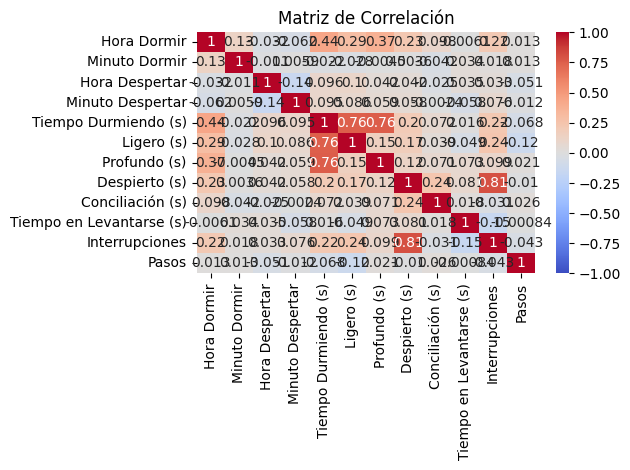

In [12]:
# Calcular la matriz de correlación
correlation_matrix = data_filtered.corr()

# Graficar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.savefig('Correlacion_alberto.jpg')
plt.show()

In [13]:
umbral_dormir_mucho = upper_bound['Tiempo Durmiendo (s)']
umbral_dormir_poco = lower_bound['Tiempo Durmiendo (s)']
umbral_caminar_poco = lower_bound['Pasos']
umbral_caminar_mucho = upper_bound['Pasos']

# Clasificar los datos en grupos
data_filtered['Grupo'] = 'Eutimia'
data_filtered.loc[(data_filtered['Tiempo Durmiendo (s)'] > umbral_dormir_mucho) & (data_filtered['Pasos'] < umbral_caminar_poco), 'Grupo'] = 'Depresión'
data_filtered.loc[(data_filtered['Tiempo Durmiendo (s)'] < umbral_dormir_poco) & (data_filtered['Pasos'] > umbral_caminar_mucho), 'Grupo'] = 'Manía'

In [14]:
data_filtered['Grupo'].value_counts()

Grupo
Eutimia      730
Depresión     12
Manía         12
Name: count, dtype: int64

In [15]:
mapeo_grupos = {'Eutimia': 1, 'Depresión': 2, 'Manía': 3}
data_filtered['Grupo_mapped'] = data_filtered['Grupo'].map(mapeo_grupos)

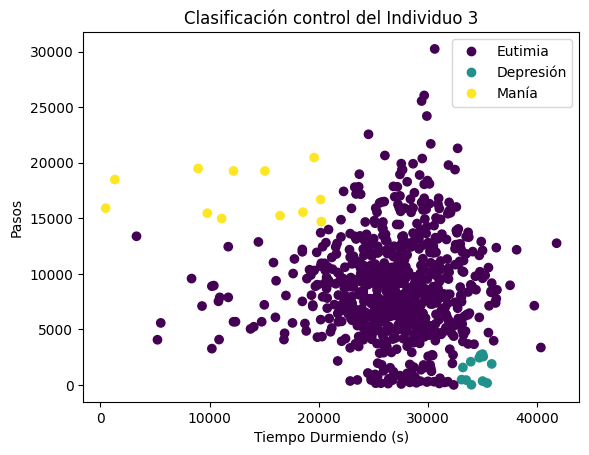

In [16]:
scatter = plt.scatter(data_filtered['Tiempo Durmiendo (s)'], data_filtered['Pasos'], c=data_filtered['Grupo_mapped'], cmap='viridis')

handles, labels = scatter.legend_elements()
legend_labels = [key for key, value in mapeo_grupos.items()]
plt.legend(handles, legend_labels)

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
plt.title('Clasificación control del Individuo 3')
plt.show()

## Propuesta modelo clasificación

In [17]:
def algoritmo_clasificacion(df):
    # Inicializar contadores para cada combinación de Grupo y Cluster
    contador = {
        'Eutimia': [0, 0, 0],
        'Depresión': [0, 0, 0],
        'Manía': [0, 0, 0]
    }

    # Contar las coincidencias
    for i in range(len(df)):
        grupo = df['Grupo'].iloc[i]
        cluster = df['Cluster'].iloc[i]
        if grupo in contador and cluster in [0, 1, 2]:
            contador[grupo][cluster] += 1

    # Determinar el grupo principal para Eutimia
    max_eutimia_value = max(contador['Eutimia'])
    grupo_eutimia = contador['Eutimia'].index(max_eutimia_value)

    # Determinar los grupos restantes (excluyendo el grupo principal de Eutimia)
    grupos_restantes = [i for i in [0, 1, 2] if i != grupo_eutimia]

    # Evaluar combinaciones para Depresión y Manía
    dep_mania_combinations = [
        (grupos_restantes[0], grupos_restantes[1]),
        (grupos_restantes[1], grupos_restantes[0])
    ]

    max_total = 0
    mejor_combination = None

    for comb in dep_mania_combinations:
        total = max_eutimia_value + contador['Depresión'][comb[0]] + contador['Manía'][comb[1]]
        if total > max_total:
            max_total = total
            mejor_combination = comb

    # Resultado final
    resultado = {
        "Eutimia": grupo_eutimia,
        "Depresión": mejor_combination[0],
        "Manía": mejor_combination[1],
        "Puntuación Total": max_total
    }

    return resultado

## Modelo KMeans

In [18]:
data_filtered = data_filtered.dropna()

In [19]:
data_filtered.shape

(754, 14)

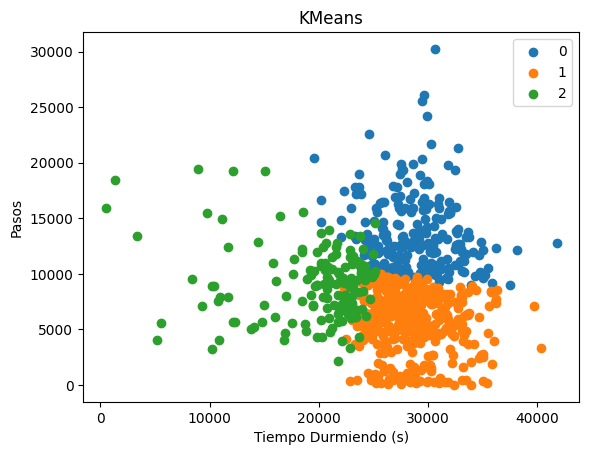

In [20]:
kmeans = KMeans(n_clusters=3, random_state=seed)
kmeans.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Profundo (s)', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada muestra
cluster_labels = kmeans.labels_
data_filtered['Cluster'] = kmeans.labels_

# Iterar sobre cada cluster y graficar los puntos correspondientes
for cluster in set(cluster_labels):
    x_cluster = data_filtered.loc[cluster_labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[cluster_labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}', cmap='viridis')

# Agregar leyenda
plt.legend()

# Personalizar el gráfico
plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('KMeans')
# Mostrar el gráfico
plt.show()

In [21]:
# Clasificación de los clústeres
agg_km = pd.DataFrame(cluster_labels)
agg_km.value_counts()

1    376
0    232
2    146
Name: count, dtype: int64

In [22]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 1, 'Depresión': 0, 'Manía': 2, 'Puntuación Total': 373}

## Agglomerative Clustering

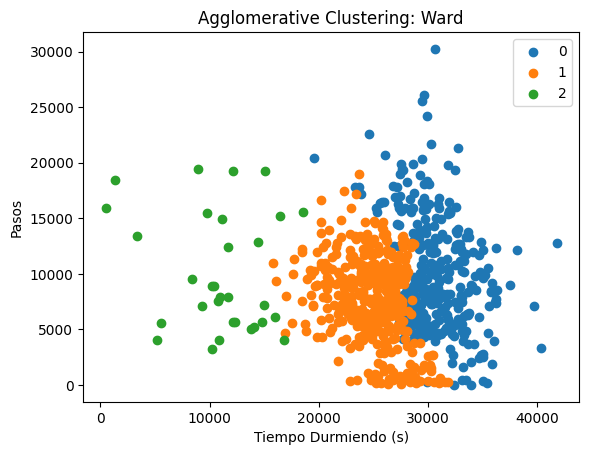

In [23]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')

# Ajustar el modelo a los datos
clustering.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Profundo (s)', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada punto
labels = clustering.labels_
data_filtered['Cluster'] = clustering.labels_

for cluster in set(labels):
    #data_cluster = data_filtered_ward[data_filtered_ward['Ward'] == cluster]
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('Agglomerative Clustering: Ward')
plt.legend()
plt.show()

In [24]:
# Clasificación de los clústeres
agg_ward = pd.DataFrame(labels)
agg_ward.value_counts()

1    411
0    312
2     31
Name: count, dtype: int64

In [25]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 1, 'Depresión': 0, 'Manía': 2, 'Puntuación Total': 430}

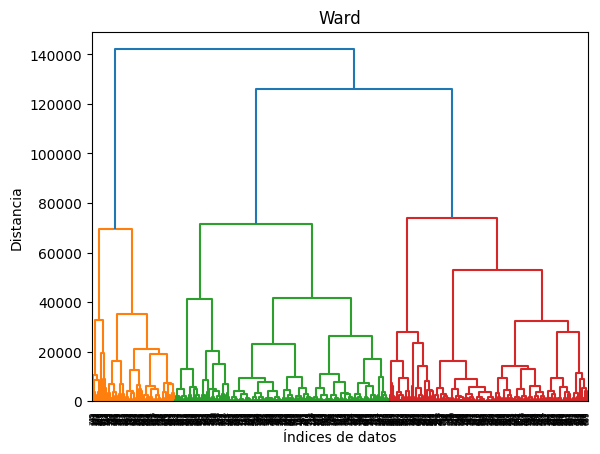

In [26]:
Z = linkage(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']], method='ward')

# Definir el corte en el dendrograma para obtener 3 clusters
k = 3
clusters = fcluster(Z, k, criterion='maxclust')

# Visualizar el dendrograma
#plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Ward')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()

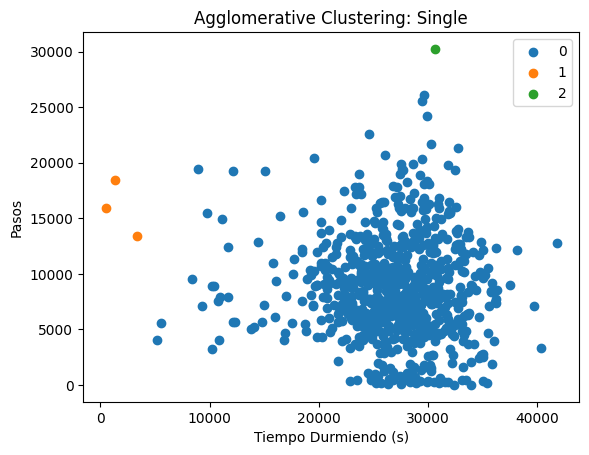

In [27]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='single')

# Ajustar el modelo a los datos
clustering.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Profundo (s)', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada punto
labels = clustering.labels_
data_filtered['Cluster'] = clustering.labels_

for cluster in set(labels):
    #data_cluster = data_filtered_ward[data_filtered_ward['Ward'] == cluster]
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('Agglomerative Clustering: Single')
plt.legend()
plt.show()

In [28]:
# Clasificación de los clústeres
agg_single = pd.DataFrame(labels)
agg_single.value_counts()

0    750
1      3
2      1
Name: count, dtype: int64

In [29]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 0, 'Depresión': 2, 'Manía': 1, 'Puntuación Total': 730}

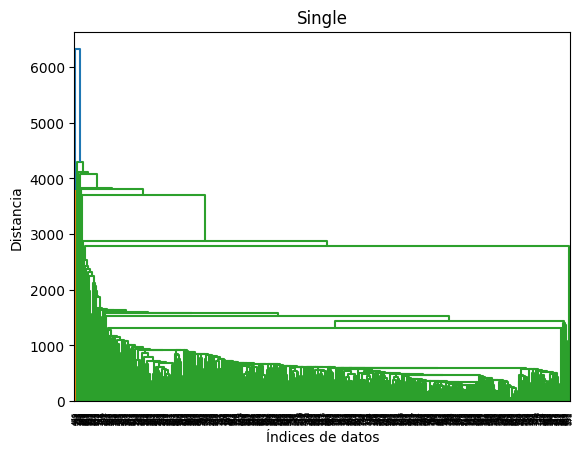

In [30]:
Z = linkage(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']], method='single')

# Definir el corte en el dendrograma para obtener 3 clusters
k = 3
clusters = fcluster(Z, k, criterion='maxclust')

# Visualizar el dendrograma
#plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Single')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()

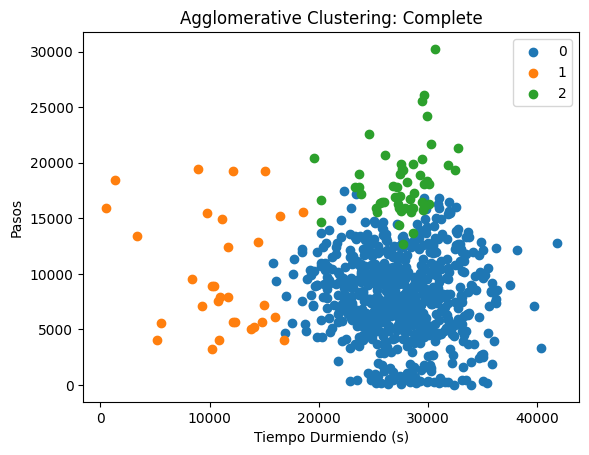

In [31]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')

# Ajustar el modelo a los datos
clustering.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Profundo (s)', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada punto
labels = clustering.labels_
data_filtered['Cluster'] = clustering.labels_

for cluster in set(labels):
    #data_cluster = data_filtered_ward[data_filtered_ward['Ward'] == cluster]
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('Agglomerative Clustering: Complete')
plt.legend()
plt.show()

In [32]:
# Clasificación de los clústeres
agg_complete = pd.DataFrame(labels)
agg_complete.value_counts()

0    670
2     53
1     31
Name: count, dtype: int64

In [33]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 0, 'Depresión': 2, 'Manía': 1, 'Puntuación Total': 667}

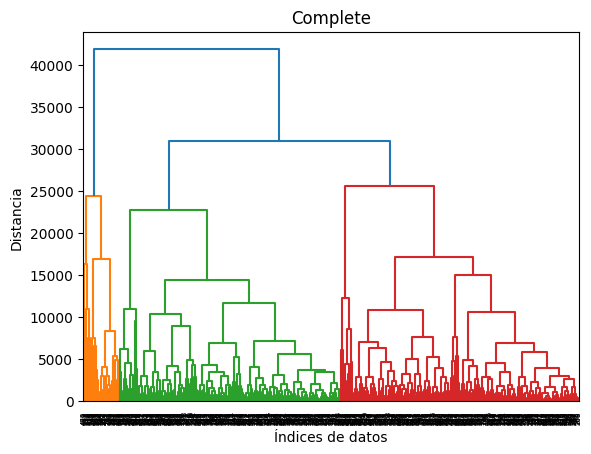

In [34]:
Z = linkage(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']], method='complete')

# Definir el corte en el dendrograma para obtener 3 clusters
k = 3
clusters = fcluster(Z, k, criterion='maxclust')

# Visualizar el dendrograma
#plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Complete')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()

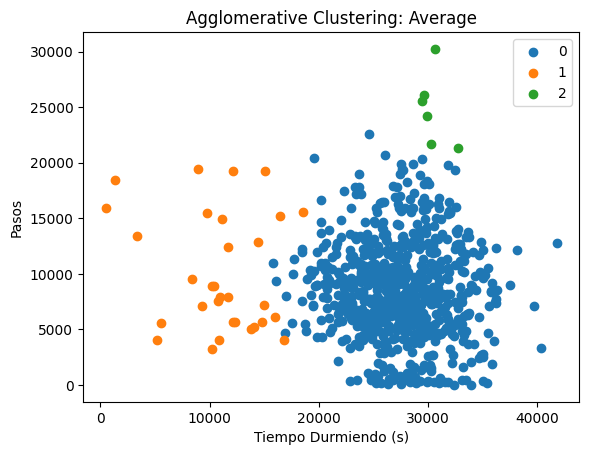

In [35]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='average')

# Ajustar el modelo a los datos
clustering.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Profundo (s)', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada punto
labels = clustering.labels_
data_filtered['Cluster'] = clustering.labels_

for cluster in set(labels):
    #data_cluster = data_filtered_ward[data_filtered_ward['Ward'] == cluster]
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('Agglomerative Clustering: Average')
plt.legend()
plt.show()

In [36]:
# Clasificación de los clústeres
agg_average = pd.DataFrame(labels)
agg_average.value_counts()

0    717
1     31
2      6
Name: count, dtype: int64

In [37]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 0, 'Depresión': 2, 'Manía': 1, 'Puntuación Total': 711}

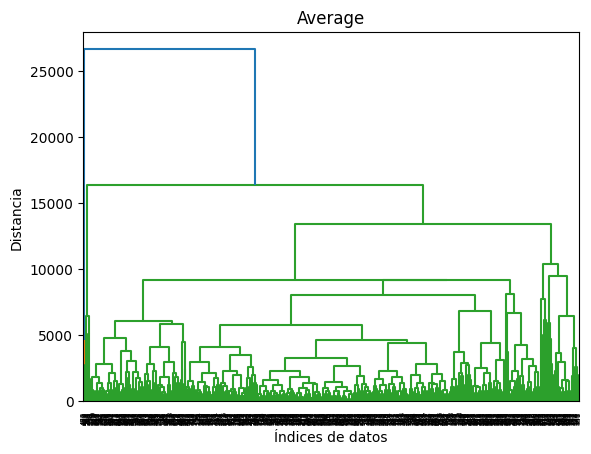

In [38]:
Z = linkage(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']], method='average')

# Definir el corte en el dendrograma para obtener 3 clusters
k = 3
clusters = fcluster(Z, k, criterion='maxclust')

# Visualizar el dendrograma
#plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Average')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()

## BDSCAN

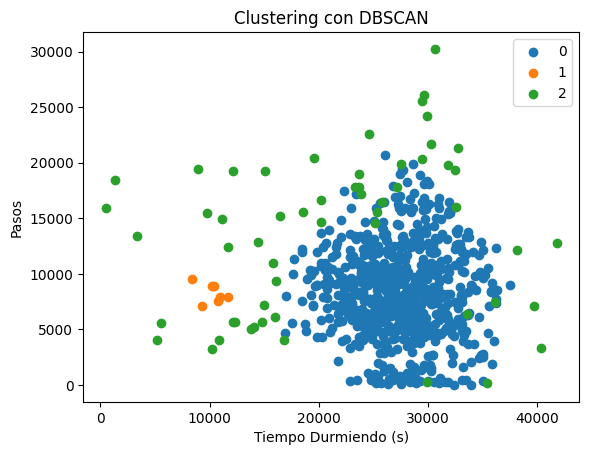

In [39]:
dbscan = DBSCAN(eps=2500, min_samples=6)
labels = dbscan.fit_predict(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Profundo (s)', 'Interrupciones']])

# Añadir las etiquetas al DataFrame original
data_filtered['Cluster'] = labels

# Crear la leyenda
for cluster in set(labels):
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

# Visualización (solo si tienes dos características)
#plt.scatter(data_filtered['Tiempo Durmiendo (s)'], data_filtered['Pasos'], c=labels, cmap='viridis')
plt.title('Clustering con DBSCAN')
plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
plt.legend([0, 1, 2])
plt.show()

In [40]:
# Clasificación de los clústeres
agg_dbscan = pd.DataFrame(labels)
agg_dbscan.value_counts()

 0    690
-1     57
 1      7
Name: count, dtype: int64

In [41]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 0, 'Depresión': 1, 'Manía': 2, 'Puntuación Total': 679}

## GMM

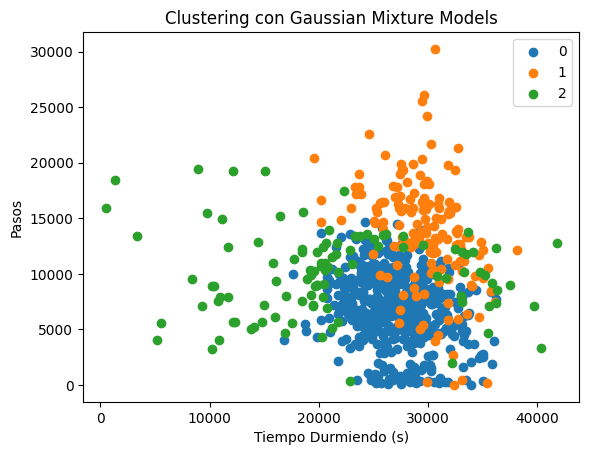

In [42]:
# Definir el número de clústeres
num_clusters = 3

# Inicializar y ajustar el modelo GMM
gmm = GaussianMixture(n_components=num_clusters, random_state=seed)
labels = gmm.fit_predict(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Profundo (s)', 'Interrupciones']])

# Añadir las etiquetas al DataFrame original
data_filtered['Cluster'] = labels

# Crear la leyenda
for cluster in set(labels):
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

# Visualización (solo si tienes dos características)
#plt.scatter(data_filtered['Tiempo Durmiendo (s)'], data_filtered['Pasos'], c=labels, cmap='viridis')
plt.title('Clustering con Gaussian Mixture Models')
plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
plt.legend()
plt.show()

In [43]:
# Clasificación de los clústeres
agg_gmm = pd.DataFrame(labels)
agg_gmm.value_counts()

0    494
1    156
2    104
Name: count, dtype: int64

In [44]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 0, 'Depresión': 1, 'Manía': 2, 'Puntuación Total': 495}